# Ablation Study

## Imports and preliminary setting

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from torchvision.models import vit_b_16
from torchvision.models import ViT_B_16_Weights

In [ ]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_file = h5py.File('../rec1501614399_export.hdf5', 'r')
test_file = h5py.File('../rec1501612590_export.hdf5', 'r')

In [ ]:
train_frames = torch.load("../vit/train_frames.pt")
test_frames = torch.load("../vit/test_frames.pt")

In [ ]:
window_size = 10

In [ ]:
train=pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])
test=pd.DataFrame(columns=['accelerator_pedal_position',
                                       'brake_pedal_status',
                                       'steering_wheel_angle'])

In [ ]:
train['accelerator_pedal_position'] = list(train_file['accelerator_pedal_position'])
train['steering_wheel_angle'] = list(train_file['steering_wheel_angle'])
train['brake_pedal_status'] = list(train_file['brake_pedal_status'])

In [ ]:
test['accelerator_pedal_position'] = list(test_file['accelerator_pedal_position'])
test['steering_wheel_angle'] = list(test_file['steering_wheel_angle'])
test['brake_pedal_status'] = list(test_file['brake_pedal_status'])

## Image representation only

In [ ]:
img_repr_dim = 768
d_model=160
n_heads=8
class PolicyNetIO(nn.Module):
  def __init__(self):
    super().__init__()
    self.img_ffn = nn.Sequential(
        nn.Linear(img_repr_dim, d_model),
        nn.ReLU()
    )
    self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_heads)

    # only taking the attention score for the last sensors timestamp
    self.head = nn.Sequential(
        nn.Linear(d_model, 3),
        nn.Sigmoid()
    )


  def forward(self, x):
    x = self.img_ffn(x)
    x = self.encoder(x)
    x = self.head(x[-1])
    return x

In [ ]:
policyNetIO=PolicyNetIO()
policyNetIO.to(device)
print("done")

done


In [ ]:
criterion = nn.L1Loss()
optimizer = optim.SGD(policyNetIO.parameters(), lr=0.01)

In [ ]:
%%time

alpha = 0.2

num_epochs = 10
losses = []

for epoch in range(num_epochs):
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(train["accelerator_pedal_position"])):

    img = train_frames[i].squeeze(0)

    label = torch.tensor([train["accelerator_pedal_position"][i]/100,
                          train["brake_pedal_status"][i],
                          (train["steering_wheel_angle"][i] + 600)/1200], dtype=torch.float32).to(device)

    if ((len(img_queue) < window_size)):
      img_queue.append(img.tolist())
      continue
    else:
      img_queue.pop(0)
      img_queue.append(img.tolist())

    if((len(img_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)

    # doing a training cycle
    output = policyNetIO(img_queue_tensor)

    optimizer.zero_grad()

    loss = criterion(output, label)

    loss.backward()
    optimizer.step()
    losses.append(loss.item())
  print(f"done epoch {epoch}.")

done epoch 0.
done epoch 1.
done epoch 2.
done epoch 3.
done epoch 4.
done epoch 5.
done epoch 6.
done epoch 7.
done epoch 8.
done epoch 9.
CPU times: user 5min 50s, sys: 4.99 s, total: 5min 55s
Wall time: 5min 50s


0.09184848925931903


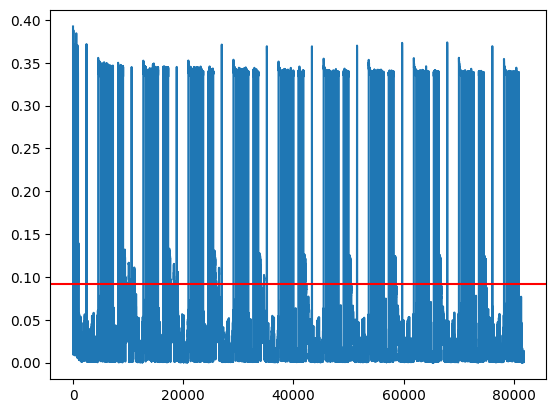

In [ ]:
print(np.mean(losses))
plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
#plt.vlines([i * len(train['aps_frame'])for i in range(num_epochs)], 0, max(losses), color = 'r')
plt.show()

In [ ]:
%%time

policyNetIO.eval()
losses = []
predictions = []
with torch.no_grad():
  #initializing queues
  img_queue = []
  sensors_queue = []
  for i in range(len(test["accelerator_pedal_position"])):

    img = test_frames[i].squeeze(0)
    label = torch.tensor([train["accelerator_pedal_position"][i]/100,
                      train["brake_pedal_status"][i],
                      (train["steering_wheel_angle"][i] + 600)/1200], dtype=torch.float32).to(device)


    if ((len(img_queue) < window_size)):
      img_queue.append(img.tolist())
      continue
    else:
      img_queue.pop(0)
      img_queue.append(img.tolist())

    if((len(img_queue) != window_size)):
      print(len(img_queue), len(sensors_queue))
      break

    # converting queues to tensors
    img_queue_tensor = torch.tensor(img_queue, dtype=torch.float32).to(device)

    # doing a training cycle
    output = policyNetIO(img_queue_tensor)

    loss = criterion(output, label)

    predictions.append(output.tolist())

    losses.append(loss.item())
    if (i % 1000) == 0:
      print(i)

1000
2000
3000
4000
5000
6000
7000
8000
CPU times: user 14.4 s, sys: 121 ms, total: 14.5 s
Wall time: 14.3 s


avg loss: 0.11933855499050199
max loss: 0.40634316205978394
min loss: 0.0007669338956475258


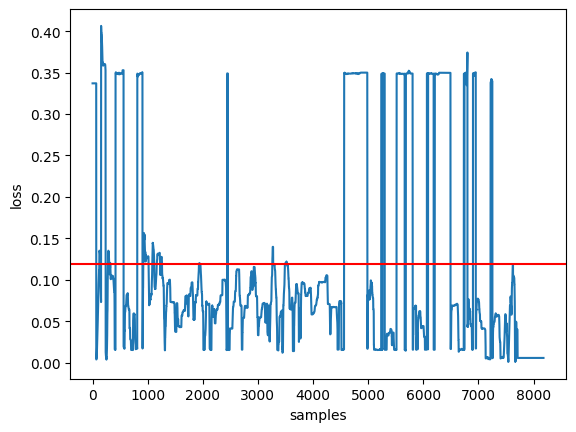

In [ ]:
print(f"avg loss: {np.mean(losses)}")
print(f"max loss: {max(losses)}")
print(f"min loss: {min(losses)}")

plt.plot(losses)
plt.axhline(np.mean(losses), color='r')
plt.xlabel("samples")
plt.ylabel("loss")
plt.show()

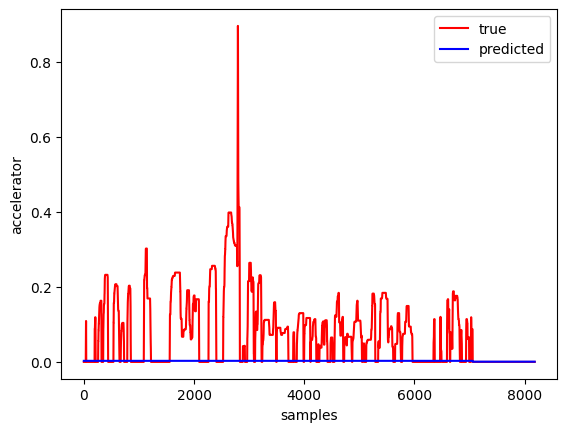

In [ ]:
accelerations = [element[0] for element in predictions]
truth = test['accelerator_pedal_position'][window_size:].tolist()
truth = [x / 100 for x in truth]
accelerations = [x for x in accelerations]
plt.plot(truth, color='r', label='true')
plt.plot(accelerations, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('accelerator')
plt.legend()
plt.savefig('ablation_acc.png')
plt.show()

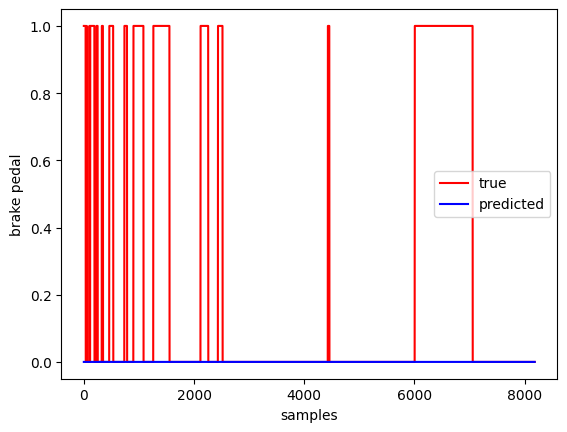

In [ ]:
brakes = [element[1] for element in predictions]
truth = test['brake_pedal_status'][window_size:].tolist()
plt.plot(truth, color='r', label='true')
plt.plot(brakes, color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('brake pedal')
plt.legend()
plt.savefig('ablation_brk.png')
plt.show()

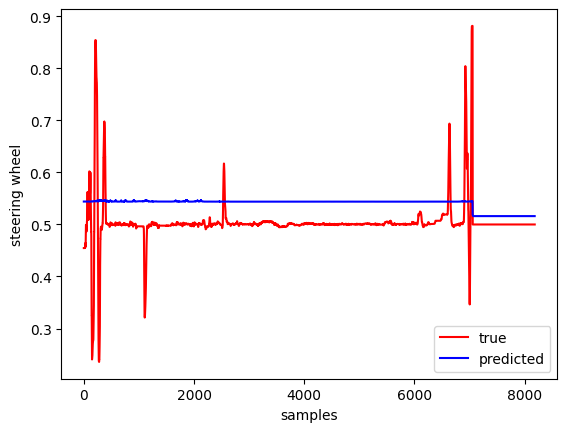

In [ ]:
steers = [element[2] for element in predictions]
truth = test['steering_wheel_angle'][window_size:].tolist()
truth = [(x + 600) / 1200 for x in truth]
steers = [x for x in steers]
plt.plot(truth[:], color='r', label='true')
plt.plot(steers[:], color='b', label='predicted')
plt.xlabel('samples')
plt.ylabel('steering wheel')
plt.legend()
plt.savefig('ablation_str.png')
plt.show()